#### Raw Layer Modeling

import libraries and functions.

In [17]:
from config import spark_session,read_csv_file
from pyspark.sql.functions import col, when, count, isnan
import matplotlib.pyplot as plt
import pandas as pd

create spark session

In [3]:
spark = spark_session()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/10 14:51:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


read raw data

In [4]:
raw_df = read_csv_file(path="/Users/sahilnagpal/Desktop/coding/competitive-programming/Projects/WALMART_SALE_PERUSAL/input_data/WALMART_SALES_DATA.csv")

capture null value counts

In [5]:
raw_df\
    .select([count(when(isnan(c), c)).alias(c) for c in raw_df.columns])\
    .show()

+-----+----+------------+------------+-----------+----------+---+------------+
|Store|Date|Weekly_Sales|Holiday_Flag|Temperature|Fuel_Price|CPI|Unemployment|
+-----+----+------------+------------+-----------+----------+---+------------+
|    0|   0|           0|           0|          0|         0|  0|           0|
+-----+----+------------+------------+-----------+----------+---+------------+



capture duplicate value

In [6]:
raw_df\
    .groupBy("Store","Date","Weekly_Sales","Holiday_Flag","Temperature","Fuel_Price","CPI","Unemployment")\
    .agg(count("*").alias("Count"))\
    .filter(col("Count")>1)\
    .show()

+-----+----+------------+------------+-----------+----------+---+------------+-----+
|Store|Date|Weekly_Sales|Holiday_Flag|Temperature|Fuel_Price|CPI|Unemployment|Count|
+-----+----+------------+------------+-----------+----------+---+------------+-----+
+-----+----+------------+------------+-----------+----------+---+------------+-----+



check data type mismatch

In [8]:
def detect_type_mismatch(spark_df):
    mismatches = {}
    for column, dtype in spark_df.dtypes:
        # Determine the expected data type based on the PySpark dtype
        if 'int' in dtype:
            expected_type = int
        elif 'float' in dtype or 'double' in dtype:
            expected_type = float
        elif 'string' in dtype:
            expected_type = str
        else:
            continue  # Skipping other data types for simplicity
        
        # Check for mismatches
        mismatches[column] = spark_df.filter(~col(column).cast('string').rlike(get_regex(expected_type)))
    
    return mismatches

def get_regex(expected_type):
    if expected_type == int:
        return r'^\d+$'
    elif expected_type == float:
        return r'^\d+(\.\d+)?$'
    elif expected_type == str:
        return r'.*'  # Any string is valid
    else:
        return r'.*'  # Default regex

In [10]:
mismatches = detect_type_mismatch(raw_df)

for column, mismatch_df in mismatches.items():
    if mismatch_df.count() > 0:
        print(f"Data type mismatches in column '{column}':")
        mismatch_df.show()
    else:
        print("Data type mismatches not found in column '{}':".format(column))

Data type mismatches not found in column 'Store':
Data type mismatches not found in column 'Date':
Data type mismatches not found in column 'Weekly_Sales':
Data type mismatches not found in column 'Holiday_Flag':
Data type mismatches not found in column 'Temperature':
Data type mismatches not found in column 'Fuel_Price':
Data type mismatches not found in column 'CPI':
Data type mismatches not found in column 'Unemployment':


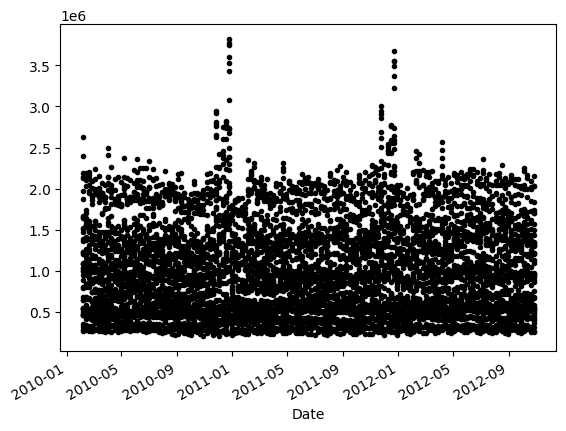

In [19]:
raw_pandas_df = raw_df.toPandas()

raw_pandas_df['Date'] = pd.to_datetime(raw_pandas_df['Date'], format='%d-%m-%Y')

# Step 5: Set the 'Date' column as the index
raw_pandas_df.set_index('Date', inplace=True)

# Step 6: Convert relevant columns to numeric types
numeric_columns = ['Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
raw_pandas_df[numeric_columns] = raw_pandas_df[numeric_columns].apply(pd.to_numeric)

# Step 7: Plot the data using Matplotlib
raw_pandas_df['Weekly_Sales'].plot(style='k.')
plt.show()
